# Sandbox notebook: 
    
This notebook is for testing functions in peices while also viewing their output, plotting etc., (the things you're not really supposed to have in tests)
It's designed to run independent of any other parts of the package, just in case.

First order of business: Try to get the model creation function to accept multiple inputs.

In [1]:
# dependencies and data visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import arviz as az

The inputs for our new function are:
   - num_neutrinos: array of floats
        - The number of muon neutrinos shot at the detector in each energy bin
   - num_nue: array of floats
        - The number of electron neutrinos detected in each energy bin
   - energy_bins: array of floats
       - bins edges for the energies we've biined data into
   - est_ss2t: float between 0 and 1
       - estimated ss2t from previous experiments, for use in the prior
   - est_dms: float above 0
       - estimated dms from previous experiments, also for use in prior
       
       
We'll use 
   - num_neutrinos: 600000
   - num_nue: array of floats, calulated below
   - energy_bins: \[0.01, 0.3, 0.7, 1.5, 2\]
   - est_ss2t: 0.5
   - est_dms: 0.8

In [2]:
# Define all out inputs

UC = 1.27 #Unit conversion factor for the coefficient on dms in the oscillation probability

energy_bins = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,1.0,1.2, 1.5, 2]) #(To be used once everything is working properly.)
num_neutrinos = np.full(energy_bins.size-1, 600000) #to fit one rate only, use an int for num_neutrinos

est_ss2t = 0.2
est_dms = 0.8

# Define L and E
# These shouldn't be exact, but for testing, we'll be lazy
E = np.zeros(energy_bins.size-1)
for i in range(E.size):
    E[i] = energy_bins[i]+(energy_bins[i+1]-energy_bins[i])/2
L = 0.5 

num_nue = num_neutrinos*est_ss2t*(np.sin(est_dms*UC*L/E))**2
true_rates =est_ss2t*(np.sin(est_dms*UC*L/E))**2
print(true_rates)

[0.00701637 0.01177368 0.16039031 0.19716378 0.16342062 0.12729676
 0.09922807 0.06332602 0.03970769 0.02700808 0.01638506]



# Begin to define what will eventually be the function that sets up our model

First, we look at taking the things we want to be inputs to the function, and making sure they are in the correct useable form

In [3]:
# make sure we can get values to use as mean energy from our bin edges when we use a truncated normal
energies = np.zeros(energy_bins.size-1)
sigmas = np.zeros(energy_bins.size-1)
for i in range(energies.size):
    energies[i] = energy_bins[i] + (energy_bins[i+1]-energy_bins[i])/2
    sigmas[i] = (energy_bins[i+1]-energy_bins[i]) # Most energy reconstructions aim for the standard deviation to be about the bin width. Later, we can upadate to make this a keyword argument
    
# When we attempt to use a uniform distribution for energy, these should be the edges      
energies_high = np.array(energy_bins[1:])
energies_low = np.array(energy_bins[:-1])

Now we set up the model

In [4]:
osc_model = pm.Model()
with osc_model:
    est_ss2t = 0.01
    est_dms = 10

        
    # We don't know the exact production point of each neutrino, so we draw from a truncated gaussian (enforcing positive distance travelled)   
    L = pm.TruncatedNormal('L', mu = 0.540, sigma = 0.015, lower = 0.02, upper = 0.6) #units of km
    
    #If this works, we'll have one E distribution for each energy bin
    #E = energies #
    pm.TruncatedNormal('E', mu = energies, sigma = sigmas, lower = energies_low, shape=energies.shape[0]) #units of GeV
        
    # Priors for unknown model parameters, centered on a prior estimate of ss2t, dms
    # Est_ss2t, est_dms defined in previous cell, will be input parameters in our function
    ss2t = pm.TruncatedNormal('sin^2_2theta', mu = est_ss2t, sigma = 0.1, lower = 0, upper = 1 ) #pm.Uniform('sin^2_2theta', 0.0001, 1)
    dms = pm.TruncatedNormal('delta_m^2', mu = est_dms, sigma = 0.1, lower = 0, shape = (1))
        
    # In the large n limit, because the number of oscillations is low, we use a Poisson approximation
    rate = pm.Deterministic('rate', ss2t*(np.sin(dms*(UC*L)/E))**2)
        
    #Likelihood of observations
    measurements = pm.Poisson('nue_flux', mu = rate*num_neutrinos, observed = num_nue)

In [5]:
osc_model


Okay, this looks good! Next order of business:
    
## Get model comparison to work with the multiple-input model

/home/jybook/anaconda3/envs/phys201b/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/jybook/anaconda3/envs/phys201b/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta_m^2, sin^2_2theta, E, L]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


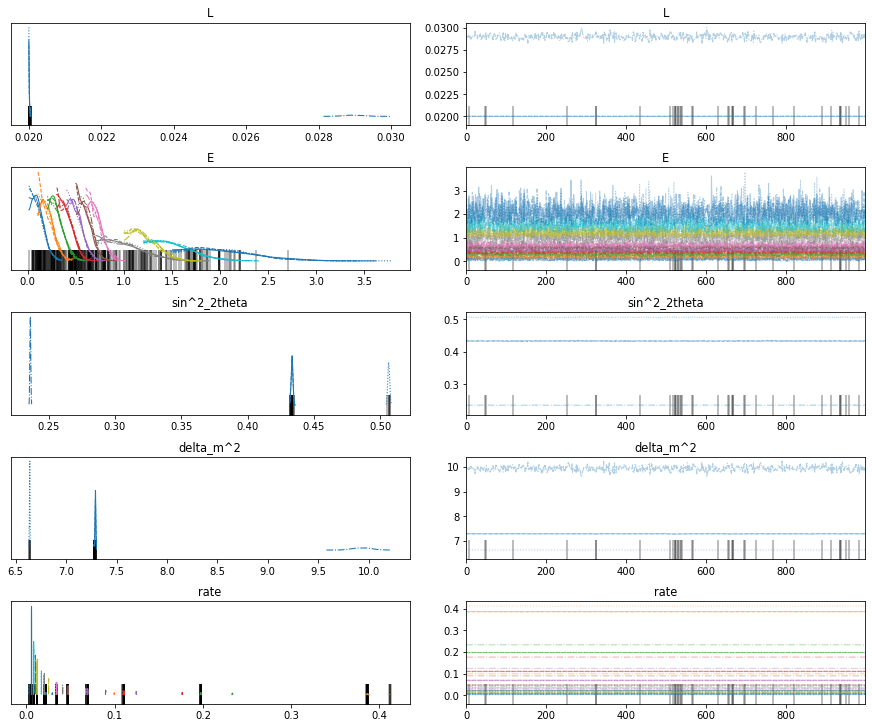

In [7]:
num_draws = 1000
tuning_steps = 1000
with osc_model:
    trace = pm.sample(num_draws, tune= tuning_steps)
    az.plot_trace(trace)

We see that we're not properly telling the sampler that there should be multiple values for E, and conseqently, the rate. What we'd like to do is have a value of E and rate for each bin, and the same value across all bins for $sin^2(2\theta)$, $\Delta m^2$, and L. 

Just in case, we wan to still check the marginal distributions of $sin^2(2\theta)$, $\Delta m^2$. However, we've defined some of these quantities incorrectly, so it's not workgin (see below)

In [8]:
params = pm.trace_to_dataframe(trace)
params_0 = pm.trace_to_dataframe(trace, chains =  0)
params_1 = pm.trace_to_dataframe(trace, chains =  1)
params_2 = pm.trace_to_dataframe(trace, chains =  2)
params_3 = pm.trace_to_dataframe(trace, chains =  2)

In [9]:
means = [params_0.mean(), params_1.mean(), params_2.mean(), params_3.mean()]
headers = ['params_0', 'params_1', 'params_2', 'params_3']
means_df = pd.concat(means, axis=1, keys=headers)

In [10]:

means_df.loc[:]

,params_0,params_1,params_2,params_3
L,0.020009,0.020008,0.020012,0.020012
E__0,0.106291,0.097932,0.101615,0.101615
E__1,0.205458,0.198454,0.192199,0.192199
E__2,0.301682,0.300843,0.297101,0.297101
E__3,0.397633,0.404641,0.403395,0.403395
E__4,0.502549,0.496370,0.502237,0.502237
E__5,0.593640,0.601854,0.598212,0.598212
E__6,0.703700,0.706184,0.695305,0.695305
E__7,0.996961,1.010986,0.985975,0.985975
E__8,1.205056,1.198872,1.205130,1.205130


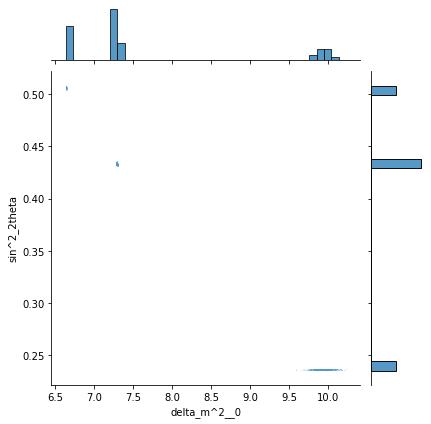

In [11]:
joint_kde = sns.jointplot(x='delta_m^2__0', y='sin^2_2theta', data=params, kind='scatter', s=0.2)

#joint_kde.ax_marg_x.set_xlim(0, 10)
#joint_kde.ax_marg_y.set_ylim(0, 1)

plt.show()

Now we want to confirm that for a given energy bin, each chain is finding $\Delta m^2$, $sin^2(2\theta)$ values that give rates consistent with those in the other chains. 

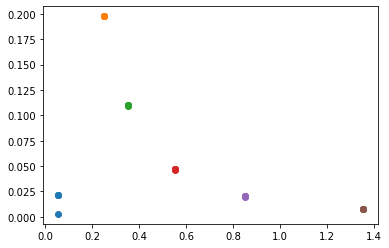

In [12]:
energy_0 = np.full(4, energies[0])
energy_2 = np.full(4, energies[2])
energy_3 = np.full(4, energies[3])
energy_5 = np.full(4, energies[5])
energy_7 = np.full(4, energies[7])
energy_9 = np.full(4, energies[9])

plt.scatter(energy_0, means_df.loc['rate__0'])
plt.scatter(energy_2, means_df.loc['rate__2'])
plt.scatter(energy_3, means_df.loc['rate__3'])
plt.scatter(energy_5, means_df.loc['rate__5'])
plt.scatter(energy_7, means_df.loc['rate__7'])
plt.scatter(energy_9, means_df.loc['rate__9'])

We note that the when the chains have lengths which agree exactly, the rates which come out of the fit agree as well. When there are slight differences in length between the chains, the largest differences between estimated rates appear in the 0.2 to 0.8 GeV region, exactly where we expect to be most sensitive to the low-energy excess.This is to be expected given the L dependence in the $sin^2(1.27\Delta m^2 L/E)$ of the oscillation formula, and illustrates one of the difficulties inherent in short-baseline experiments.

In [13]:
df_trace = pm.trace_to_dataframe(trace)
q = df_trace.quantile([0.16,0.50,0.84], axis=0)
print("delta_m^2 = {:.2f} + {:.2f} - {:.2f}".format(q['delta_m^2__0'][0.50], 
                                            q['delta_m^2__0'][0.84]-q['delta_m^2__0'][0.50],
                                            q['delta_m^2__0'][0.50]-q['delta_m^2__0'][0.16]))
print("sin^2_2theta = {:.1f} + {:.1f} - {:.1f}".format(q['sin^2_2theta'][0.50], 
                                            q['sin^2_2theta'][0.84]-q['sin^2_2theta'][0.50],
                                            q['sin^2_2theta'][0.50]-q['sin^2_2theta'][0.16]))
    
    

delta_m^2 = 7.29 + 2.61 - 0.65
sin^2_2theta = 0.4 + 0.1 - 0.2


<ipython-input-21-69ad8fc94ec9>:5: RuntimeWarning: divide by zero encountered in true_divide
  dms_0 = E/(UC*L) * np.arcsin(np.sqrt(rate[0]/ss2t))
<ipython-input-21-69ad8fc94ec9>:5: RuntimeWarning: invalid value encountered in arcsin
  dms_0 = E/(UC*L) * np.arcsin(np.sqrt(rate[0]/ss2t))
<ipython-input-21-69ad8fc94ec9>:6: RuntimeWarning: divide by zero encountered in true_divide
  dms_3 = E/(UC*L) * np.arcsin(np.sqrt(rate[3]/ss2t))
<ipython-input-21-69ad8fc94ec9>:6: RuntimeWarning: invalid value encountered in arcsin
  dms_3 = E/(UC*L) * np.arcsin(np.sqrt(rate[3]/ss2t))


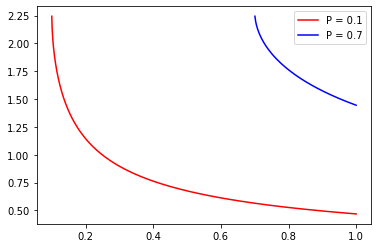

In [21]:
E = 1.0
L = 0.54
ss2t = np.linspace(0, 1, 1000)
rate = [0.1, 0.2, 0.5, 0.7]
dms_0 = E/(UC*L) * np.arcsin(np.sqrt(rate[0]/ss2t))
dms_3 = E/(UC*L) * np.arcsin(np.sqrt(rate[3]/ss2t))


plt.plot(ss2t, dms_0, color='red',label="P = 0.1")
plt.plot(ss2t, dms_3, color='blue', label = "P = 0.7")
plt.legend()

In [15]:
means_df

,params_0,params_1,params_2,params_3
L,0.020009,0.020008,0.020012,0.020012
E__0,0.106291,0.097932,0.101615,0.101615
E__1,0.205458,0.198454,0.192199,0.192199
E__2,0.301682,0.300843,0.297101,0.297101
E__3,0.397633,0.404641,0.403395,0.403395
E__4,0.502549,0.496370,0.502237,0.502237
E__5,0.593640,0.601854,0.598212,0.598212
E__6,0.703700,0.706184,0.695305,0.695305
E__7,0.996961,1.010986,0.985975,0.985975
E__8,1.205056,1.198872,1.205130,1.205130


In [16]:
L = means_df.loc['L']
ss2t = np.linspace(0.0, 1, 1000)

def give_dms(energy, L, rate, ss2t):
    dms = energy/(UC*L) * np.arcsin(np.sqrt(rate/ss2t))
    return dms

<ipython-input-16-80202ad2aa9f>:5: RuntimeWarning: divide by zero encountered in true_divide
  dms = energy/(UC*L) * np.arcsin(np.sqrt(rate/ss2t))
<ipython-input-16-80202ad2aa9f>:5: RuntimeWarning: invalid value encountered in arcsin
  dms = energy/(UC*L) * np.arcsin(np.sqrt(rate/ss2t))
<ipython-input-16-80202ad2aa9f>:5: RuntimeWarning: divide by zero encountered in true_divide
  dms = energy/(UC*L) * np.arcsin(np.sqrt(rate/ss2t))
<ipython-input-16-80202ad2aa9f>:5: RuntimeWarning: invalid value encountered in arcsin
  dms = energy/(UC*L) * np.arcsin(np.sqrt(rate/ss2t))
<ipython-input-16-80202ad2aa9f>:5: RuntimeWarning: divide by zero encountered in true_divide
  dms = energy/(UC*L) * np.arcsin(np.sqrt(rate/ss2t))
<ipython-input-16-80202ad2aa9f>:5: RuntimeWarning: invalid value encountered in arcsin
  dms = energy/(UC*L) * np.arcsin(np.sqrt(rate/ss2t))
<ipython-input-16-80202ad2aa9f>:5: RuntimeWarning: divide by zero encountered in true_divide
  dms = energy/(UC*L) * np.arcsin(np.sqrt(r

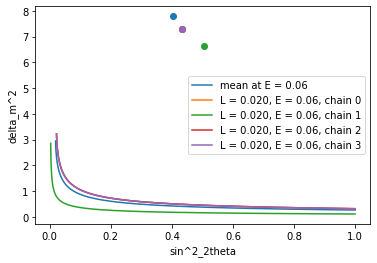

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('delta_m^2')
ax1.set_xlabel('sin^2_2theta')

for i in [0]:#play around with this! Choose any energy bin to investigate (I recommend only one or two at a time, otherwise the legend takes over.)
    E_str = "{:.2f}".format(energies[i])
    labe = 'mean at E = ' + E_str
    rate_str = 'rate__' + str(i)
        
    ax1.plot(ss2t, give_dms(energies[i], params.mean().loc['L'], params.mean().loc[rate_str], ss2t), label = labe)
    ax1.scatter(params.mean().loc['sin^2_2theta'], params.mean().loc['delta_m^2__0'])      
    for chain in range(0, 4):
        rate = means_df.loc[rate_str]
        L_str = "{:.3f}".format(L[chain])
        label_str = 'L = ' + L_str +', E = '+ E_str + ', chain ' + str(chain)
        ax1.plot(ss2t, give_dms(energies[i], L[chain], rate[chain], ss2t), label = label_str)
        ax1.scatter(means_df.loc['sin^2_2theta'][chain], means_df.loc['delta_m^2__0'][chain])
ax1.legend()